In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.timeseries import LombScargle
from scipy.integrate import RK45, DOP853
from scipy.stats import chi2

### Plotting code

In [2]:
def plotTimeSeries(t, y, min_freq=None, max_freq=None, nq=None, spp=10, true_freq=None, LS_xlim=None, plot_harmonics=False, title=None):
    frequency, power = LombScargle(t,y).autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, nyquist_factor=nq, samples_per_peak=spp)
    
    fig = plt.figure(figsize=(16,8))
    gs = gridspec.GridSpec(2, 2, figure=fig)
    ax00 = fig.add_subplot(gs[0, :])
    ax00.plot(t, y)
    ax00.set_xlabel('time')
    ax00.set_ylabel('signal')
    if title is not None:
        ax00.set_title('{0} time series'.format(title))
    else:
        ax00.set_title('time series')

    ax10 = fig.add_subplot(gs[1, 0])
    ax10.hist(y,bins=30)
    ax10.set_xlabel('signal')
    ax10.set_ylabel('count')
    ax10.set_title('Histogram')


    ax11 = fig.add_subplot(gs[1, 1])
    ax11.plot(frequency, power)
    ax11.set_xlabel('frequency [cycles/time unit]')
    ax11.set_ylabel('power [dimensionless]')
    ax11.set_title('Lomb-Scargle periodogram')
    if LS_xlim is not None:
        ax11.set_xlim(LS_xlim)
    if true_freq is not None:
        [ax11.axvline(x, color='r',lw=0.5) for x in true_freq]
        if plot_harmonics is True:
            [ax11.axvline(x, color='b',lw=0.5) for x in true_freq/2.]
            [ax11.axvline(x, color='g',lw=0.5) for x in true_freq/3.]
        
    plt.show()
    return 

### Gaussian noise

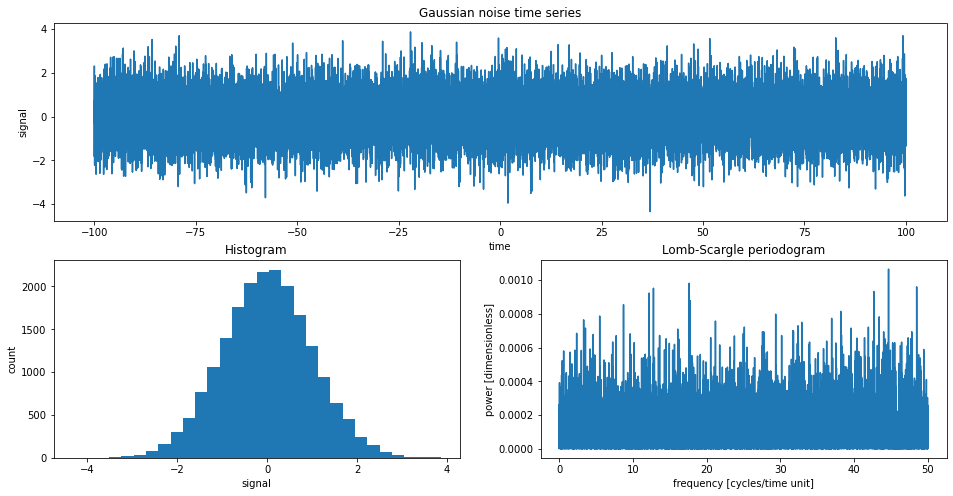

In [3]:
np.random.seed(8421)

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

gaussianNoise = np.random.normal(0.,1.,len(t))
plotTimeSeries(t, gaussianNoise,min_freq=(1./baseline),max_freq=(1./(2.*dt)),title="Gaussian noise")

### Multiperiodic signals

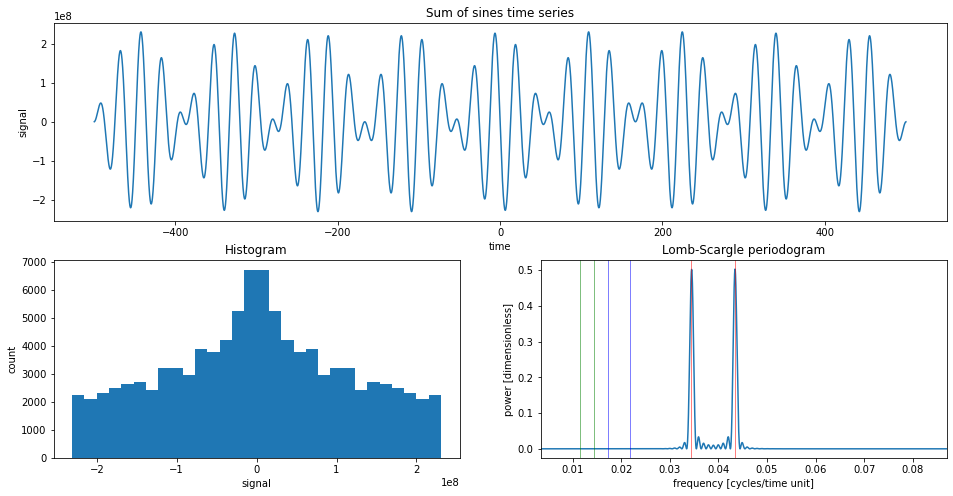

In [4]:
dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

v1 = 2*np.pi*(1./23.)
v2 = 2*np.pi*(1./29.)

trueFreqs = np.array((1./23.,1./29.))

simplePeriodic = (np.sin(t*v1) + np.sin(t*v2))
simplePeriodic = simplePeriodic/np.mean(simplePeriodic)
plotTimeSeries(t, simplePeriodic,min_freq=(1./baseline),max_freq=(1./(2.*dt)), nq=10, spp=100, 
               LS_xlim = (0.1*np.min(trueFreqs),2*np.max(trueFreqs)), plot_harmonics=True, 
               true_freq=trueFreqs,title="Sum of sines")

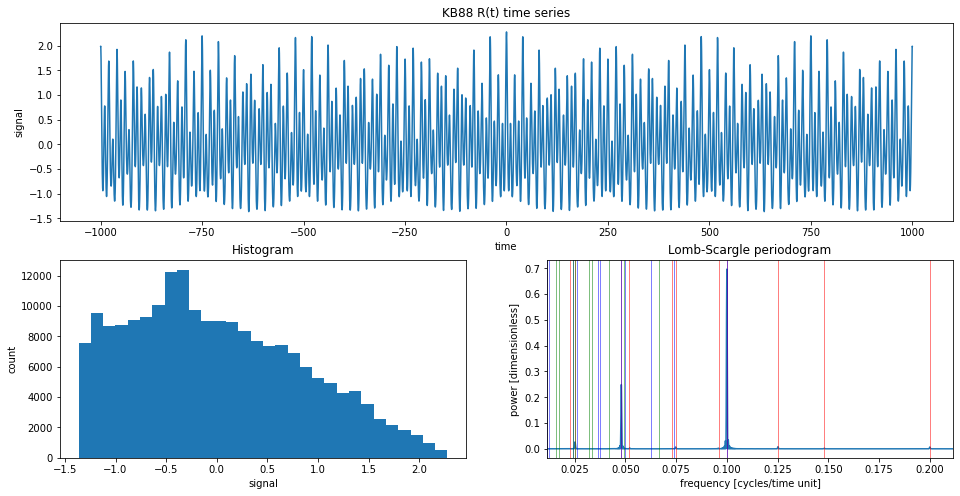

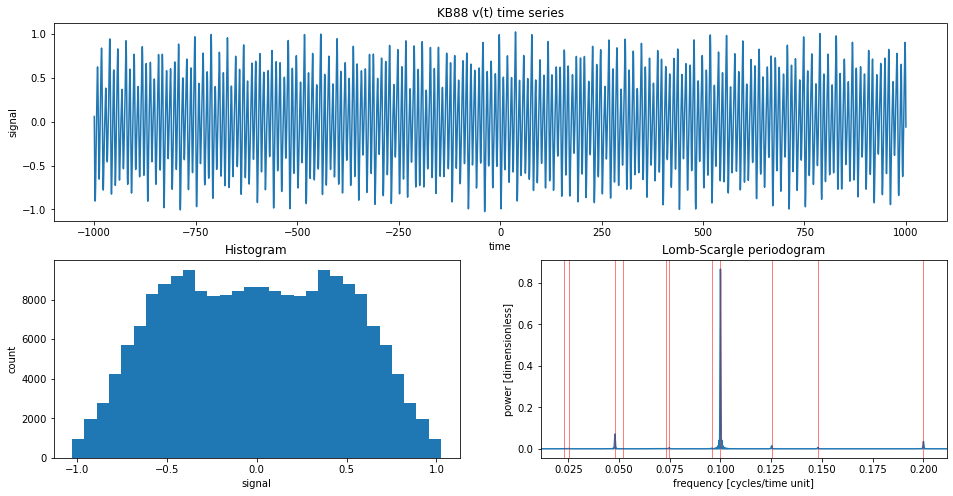

In [5]:
# multi-periodic signal from Kovacs & Buchler 1988
def KB88(t,a1=1.0,a2=0.6,a3=0.2,v1=0.1,v2=0.048,v3=0.0252):
    w1 = 2*np.pi*v1
    w2 = 2*np.pi*v2
    w3 = 2*np.pi*v3
    
    # length t + 1
    t2 = np.append(t, t[-1] + np.mean(t[1:] - t[0:-1]))
    
    r = a1 * np.cos(w1 * t2) + a2 * np.cos(w2 * t2) + a3 * np.cos(w3 * t2) \
        + 0.5 * a1 * a3 * (np.cos( (w1 + w3) * t2) + np.cos( (w1 - w3) * t2)) \
        + 0.1 * a2 * a3 * (np.cos( (w2 + w3) * t2) + np.cos( (w2 - w3) * t2)) \
        + 0.1 * a1 * a2 * (np.cos( (w1 + w2) * t2) + np.cos( (w1 - w2) * t2)) \
        + 0.1 * a1**2 * np.cos(2. * w1 * t2) \
        + 0.1 * a2**2 * np.cos(2. * w2 * t2)
    
    v = (r[1:] - r[0:-1])/np.mean(t[1:] - t[0:-1])
        
    return r[:-1], v

dt = 0.01
tmin = -1000.
tmax = 1000.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

multiPeriodic_r, multiPeriodic_v = KB88(t)

trueFreqs = np.array((0.1, 0.048, 0.0252, 0.1+0.048, 0.1-0.048, 0.048+0.0252, 0.048-0.0252, 0.1+0.0252, 0.1-0.0252, 2*0.1, 2*0.048,))

plotTimeSeries(t, multiPeriodic_r, min_freq=0.5*np.min(trueFreqs),max_freq=np.max(trueFreqs)+0.5*np.min(trueFreqs), nq=10, spp=100, 
               LS_xlim = (0.5*np.min(trueFreqs),np.max(trueFreqs)+0.5*np.min(trueFreqs)), true_freq=trueFreqs, plot_harmonics=True, title="KB88 R(t)")
plotTimeSeries(t, multiPeriodic_v, min_freq=0.5*np.min(trueFreqs),max_freq=np.max(trueFreqs)+0.5*np.min(trueFreqs), nq=10, spp=100, 
               LS_xlim = (0.5*np.min(trueFreqs),np.max(trueFreqs)+0.5*np.min(trueFreqs)), true_freq=trueFreqs, title="KB88 v(t)")

### Rossler system 

In [6]:
def Rossler_FPs(a,b,c):
    x1 = (c + np.sqrt(c**2 - 4*a*b))/2.
    y1 = (-c - np.sqrt(c**2 - 4*a*b))/(2.*a)
    z1 = (c + np.sqrt(c**2 - 4*a*b))/(2.*a)
    
    x2 = (c - np.sqrt(c**2 - 4*a*b))/2.
    y2 = (-c + np.sqrt(c**2 - 4*a*b))/(2.*a)
    z2 = (c - np.sqrt(c**2 - 4*a*b))/(2.*a)
    
    return np.array((x1,y1,z1)), np.array((x2,y2,z2))

fp1, fp2 = Rossler_FPs(a=0.2,b=0.2,c=4.8)
print(fp1)
print(fp2)

[  4.79165215 -23.95826074  23.95826074]
[ 0.00834785 -0.04173926  0.04173926]


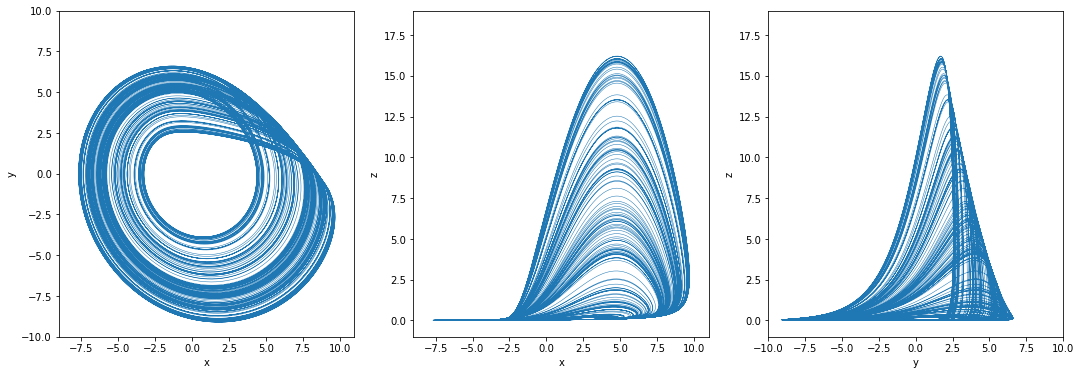

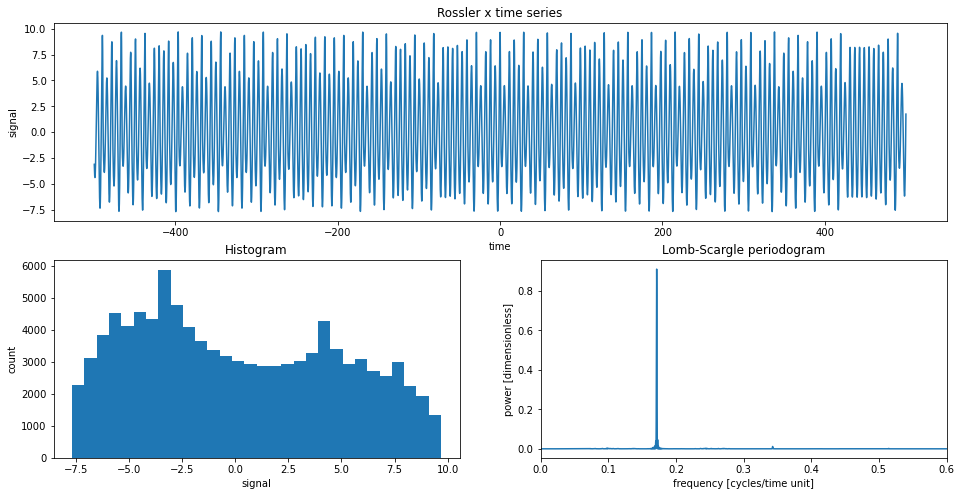

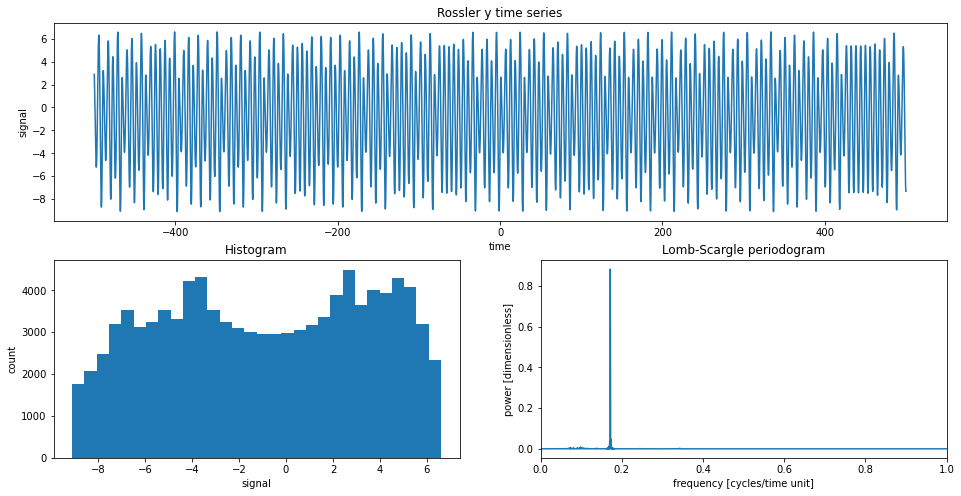

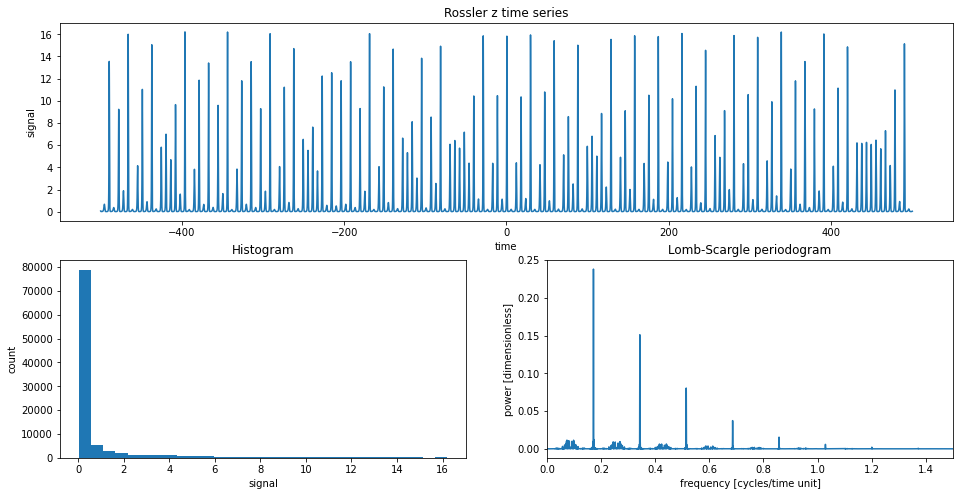

In [7]:
def Rossler_vel(t,r):
    """
    r is an array (x, y, z)
    return xdot, ydot, zdot
    """
    a=0.2
    b=0.2
    c=4.8
    
    x = r[0]
    y = r[1]
    z = r[2]
    
    v_x = -y - z
    v_y = x + a*y
    v_z = b + z*(x - c)
    
    return np.array((v_x, v_y, v_z))

#r0 = np.array((0.1, -7, 0.1))
# just in case, to avoid transients, choose as IC the 5000th iteration of the above IC
r0 = np.array((-3.07896671,  2.91997852,  0.07254192))

# fixed point experiment 
# need to do it this way because it's very very sensitive to ICs. truncation error is enough to ruin it
# (both unstable! trajectories roll off and down to the attractor.)
fp1_x = 4.79165215
fp1_y = -23.95826074
fp1_z = 23.95826074
#r0 = np.array((fp1_x, fp1_y, fp1_z))

fp2_x = 0.00834785
fp2_y = -0.04173926
fp2_z = 0.04173926
#r0 = np.array((fp2_x, fp2_y, fp2_z))

dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

rossler = RK45(fun=Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

rossler_r = np.empty((Nsteps,3))
rossler_t = np.empty((Nsteps))
for i in range(Nsteps):
    rossler.step()
    rossler_t[i] = rossler.t
    rossler_r[i] = rossler.y

#print(rossler_r[5000])

fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(rossler_r[:,0],rossler_r[:,1],lw=0.5)
axes[0].set_xlim(-9,11)
axes[0].set_ylim(-10,10)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(rossler_r[:,0],rossler_r[:,2],lw=0.5)
axes[1].set_xlim(-9,11)
axes[1].set_ylim(-1,19)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(rossler_r[:,1],rossler_r[:,2],lw=0.5)
axes[2].set_xlim(-10,10)
axes[2].set_ylim(-1,19)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

plotTimeSeries(rossler_t,rossler_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,0.6),title="Rossler x")
plotTimeSeries(rossler_t,rossler_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,1.),title="Rossler y")
plotTimeSeries(rossler_t,rossler_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,1.5),title="Rossler z")

### Rotated Rossler system (inspired by Letellier & Aguirre 2002)

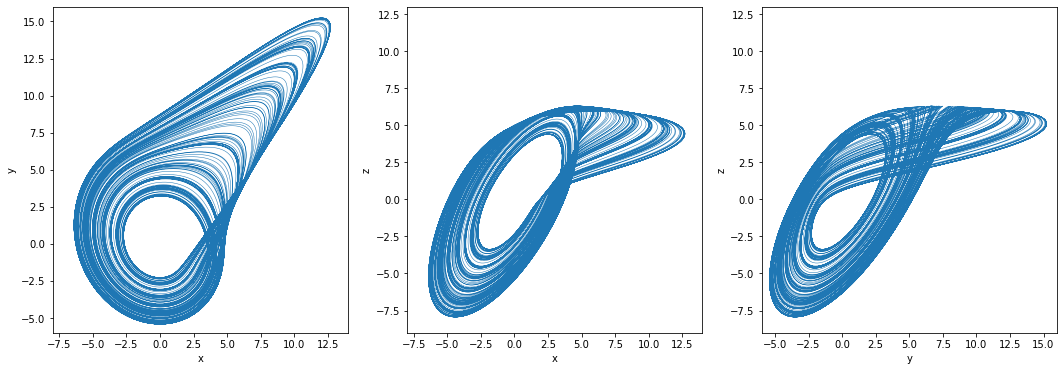

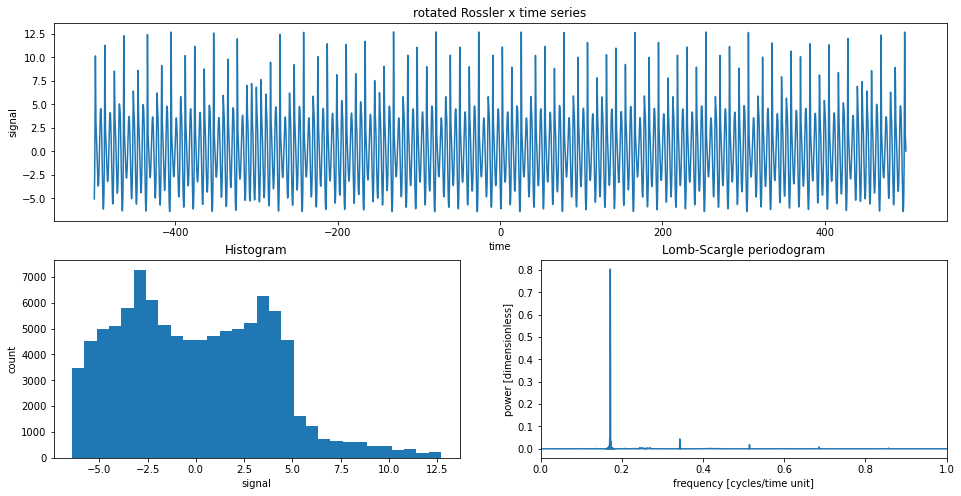

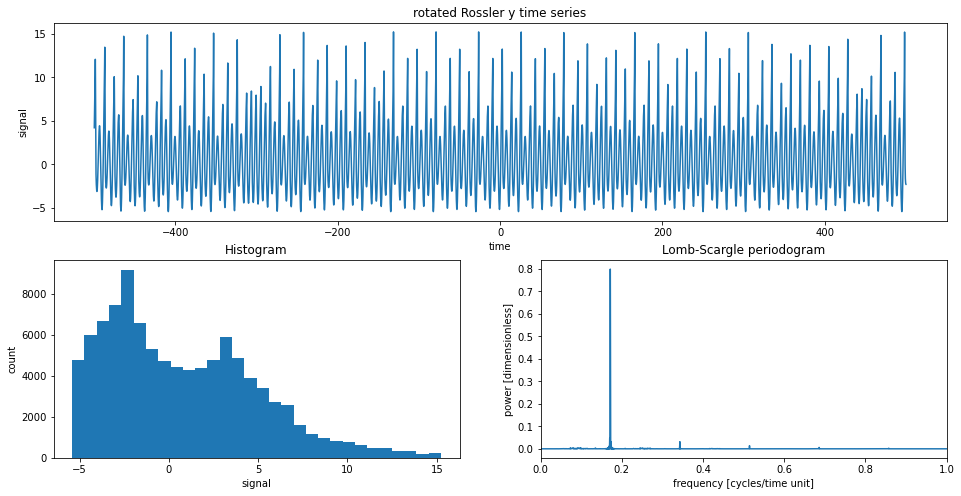

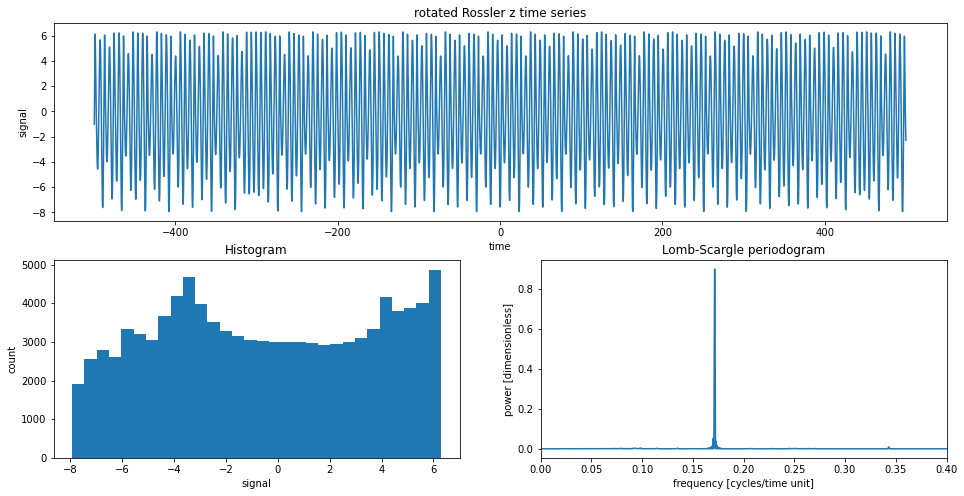

In [8]:
def rotated_Rossler_vel(t,r):
    """
    r is an array (x, y, z)
    return xdot, ydot, zdot
    """
    a=0.2
    b=0.2
    c=4.8
    
    x = r[0]
    y = r[1]
    z = r[2]
    
    # Note: equations (18) of Letellier & Aguirre 2002 are WRONG---these are right.
    #v_x = -0.5*((1 - a + c)*x + (a - 1 + c)*y - (1 + a + c)*z - 2*b) + 0.25*(x + y - z)*(z + y - x)
    #v_y = b + 0.25*(x + y - z)*(z + y - x - 2*c) - x
    #v_z = -x + 0.5*(x*(a - 1) + y*(1 - a) + z*(1 + a))
    
    #or, renormalizing by 1/sqrt(2): (i.e., x' = (1/sqrt(2))*(y+z), etc.
    v_x = 0.5*(x*(a - 1) + y*(1 - a) + z*(1 + a) + np.sqrt(2)*b + (x + y - z)*((np.sqrt(2)/2)*(y + z - x) - c))
    v_y = (1./np.sqrt(2))*b + 0.5*(x + y - z)*((np.sqrt(2)/2)*(z + y - x) - c) - x
    v_z = -x + 0.5*(x*(a - 1) + y*(1 - a) + z*(1 + a))
    
    return np.array((v_x, v_y, v_z))

#r0 = (1./np.sqrt(2))*np.array((2.9+0.07, 0.07-3.08, -3.08+2.9))
# just in case, to avoid transients, choose as IC the 5000th iteration of the above IC
r0 = np.array((-5.09005781,4.17054396,-1.09101873))
# fixed point experiment
# need to do it this way because it's very very sensitive to ICs. truncation error is enough to ruin it
# (both unstable! trajectories roll off and down to the attractor.)
fp1_x = 4.79165215
fp1_y = -23.95826074
fp1_z = 23.95826074
#r0 = (1./np.sqrt(2))*np.array((fp1_y + fp1_z, fp1_x+fp1_z, fp1_x+fp1_y))

fp2_x = 0.00834785
fp2_y = -0.04173926
fp2_z = 0.04173926
#r0 = (1./np.sqrt(2))*np.array((fp2_y + fp2_z, fp2_x+fp2_z, fp2_x+fp2_y))



dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

rotated_rossler = RK45(fun=rotated_Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

rotated_rossler_r = np.empty((Nsteps,3))
rotated_rossler_t = np.empty((Nsteps))
for i in range(Nsteps):
    rotated_rossler.step()
    rotated_rossler_t[i] = rotated_rossler.t
    rotated_rossler_r[i] = rotated_rossler.y
    #print(i, rotated_rossler_r[i])
#print(rotated_rossler_r[5000])

fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(rotated_rossler_r[:,0],rotated_rossler_r[:,1],lw=0.5)
axes[0].set_xlim(-8,14)
axes[0].set_ylim(-6,16)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(rotated_rossler_r[:,0],rotated_rossler_r[:,2],lw=0.5)
axes[1].set_xlim(-8,14)
axes[1].set_ylim(-9,13)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(rotated_rossler_r[:,1],rotated_rossler_r[:,2],lw=0.5)
axes[2].set_xlim(-6,16)
axes[2].set_ylim(-9,13)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

plotTimeSeries(rotated_rossler_t,rotated_rossler_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,1.),title="rotated Rossler x")
plotTimeSeries(rotated_rossler_t,rotated_rossler_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,1.),title="rotated Rossler y")
plotTimeSeries(rotated_rossler_t,rotated_rossler_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,0.4),title="rotated Rossler z")

### Lorenz system

In [9]:
def Lorenz_FPs(sigma, beta, rho):
    x1 = np.sqrt( beta * (rho - 1))
    y1 = x1
    z1 = rho - 1
    
    x2 = -x1
    y2 = -y1
    z2 = z1
    
    if rho < sigma*((sigma + beta + 3.)/(sigma - beta - 1.)):
        print("stable")
    else:
        print("unstable")
    
    return np.array((x1,y1,z1)), np.array((x2,y2,z2))

fp1, fp2 = Lorenz_FPs(sigma=10., beta=8./3., rho=28.)
print(fp1)
print(fp2)

unstable
[ 8.48528137  8.48528137 27.        ]
[-8.48528137 -8.48528137 27.        ]


In [10]:
def Lorenz_vel(t,r):
    """
    r is an array (x, y, z)
    return xdot, ydot, zdot
    """
    sigma=10.
    beta=8./3.
    rho=28.
    
    x = r[0]
    y = r[1]
    z = r[2]
    
    v_x = sigma*(y-x)
    v_y = x*(rho-z) - y
    v_z = x*y - beta*z
    
    return np.array((v_x, v_y, v_z))


#r0 = np.array((1., 1., 1.))
# the above IC isn't yet on the attractor, has a brief transient; the below is chosen as the 5000th iteration of the above
# and seems to be safely on the attractor
r0 = np.array((-13.29390985, -16.32060497,  29.90864944))


#fixed point experiments
# because rho > 1, expect 2 fixed points (at the center of the lobes)
# points are both stable if rho < sigma * ((sigma + beta + 3)/(sigma - beta - 1))
# given the choice of parameters above, the RHS of that inequality is ~= 24.7
# so we expect the two FPs to be *unstable*.
fp1_x = 8.48528137
fp1_y = 8.48528137
fp1_z = 27.

fp2_x = -fp1_x
fp2_y = -fp1_y
fp2_z = fp1_z

#r0 = np.array((fp1_x, fp1_y, fp1_z))
#r0 = np.array((fp2_x, fp2_y, fp2_z))

dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

lorenz = RK45(fun=Lorenz_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

lorenz_r = np.empty((Nsteps,3))
lorenz_t = np.empty((Nsteps))
for i in range(Nsteps):
    lorenz.step()
    lorenz_t[i] = lorenz.t
    lorenz_r[i] = lorenz.y


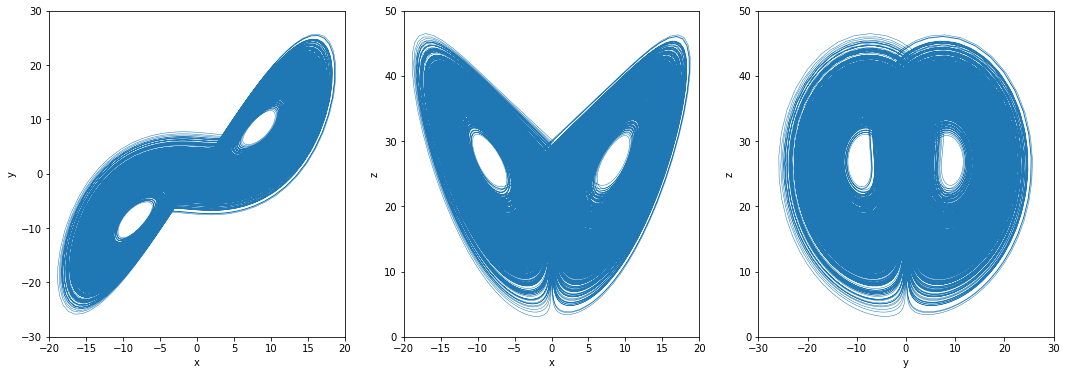

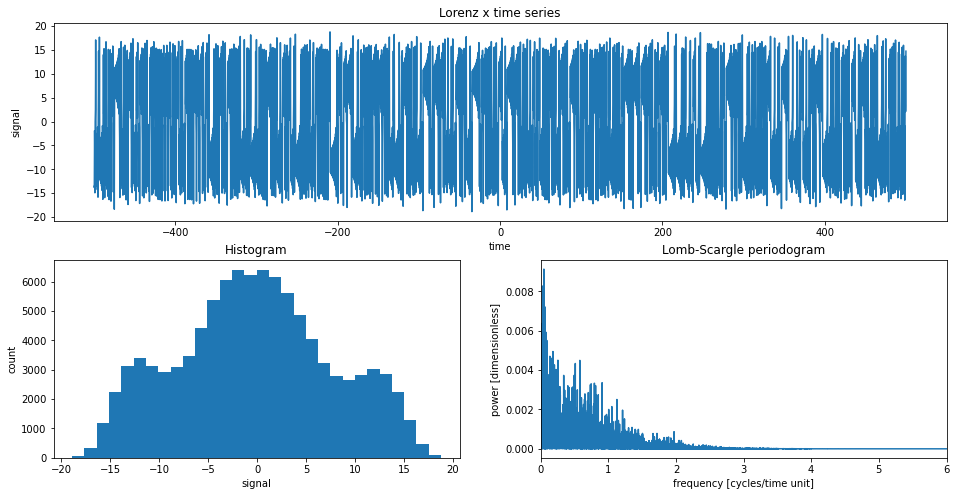

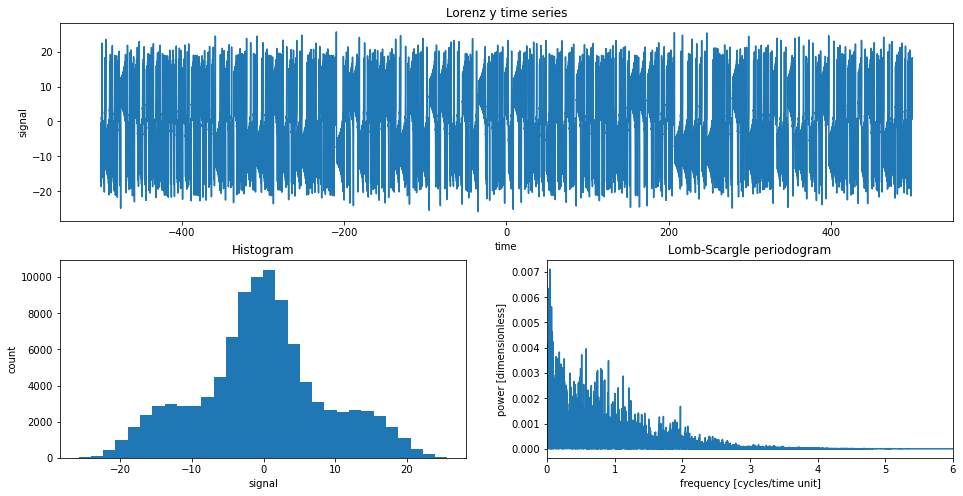

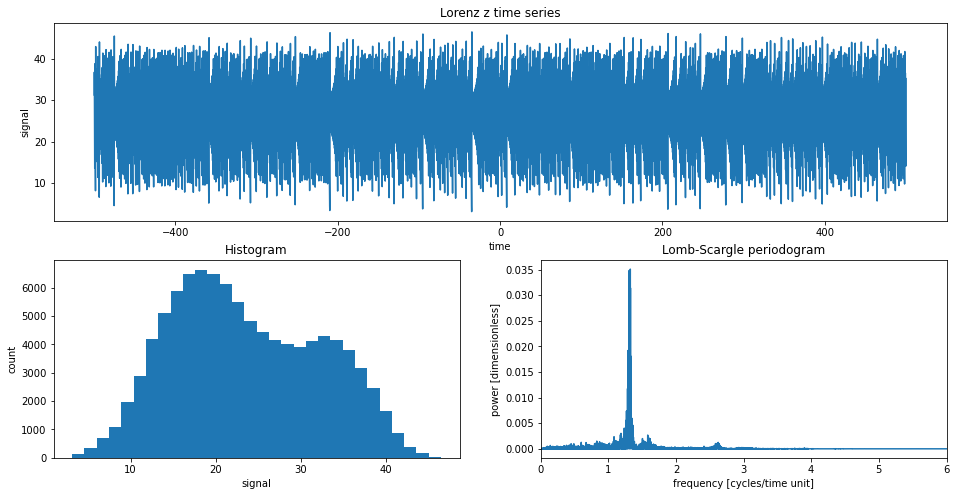

In [11]:
fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(lorenz_r[:,0],lorenz_r[:,1],lw=0.5)
axes[0].set_xlim(-20,20)
axes[0].set_ylim(-30,30)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(lorenz_r[:,0],lorenz_r[:,2],lw=0.5)
axes[1].set_xlim(-20,20)
axes[1].set_ylim(0,50)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(lorenz_r[:,1],lorenz_r[:,2],lw=0.5)
axes[2].set_xlim(-30,30)
axes[2].set_ylim(0,50)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

plotTimeSeries(lorenz_t,lorenz_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz x")
plotTimeSeries(lorenz_t,lorenz_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz y")
plotTimeSeries(lorenz_t,lorenz_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz z")


## Number of data points 

In [12]:
print(np.shape(rossler_t))
print(np.shape(rossler_r))

(100000,)
(100000, 3)


In [13]:
print(np.shape(rotated_rossler_t))
print(np.shape(rotated_rossler_r))

(100000,)
(100000, 3)


In [14]:
print(np.shape(lorenz_t))
print(np.shape(lorenz_r))

(100000,)
(100000, 3)


# Choose time delay

### Fraser & Swinney 1986 (used 32,768 points for the Belousov-Zhabotinskii rxn; 1,048,576 points for the Rossler system)

### note: keep track of time taken per choice of delay time

In [15]:
# first, need a way of discretizing the data (X(t), X(t+T)) into 2D bins

def bin2D(timeSeries, tauIdx,plotTitle=None):
    x = timeSeries[:-tauIdx]
    y = timeSeries[tauIdx:]
    #print(timeSeries)
    #print(x)
    #print(y)
    fig, axes = plt.subplots(1,2,figsize=(16,6))
    axes[0].hist2d(x,y,bins=(100,100),cmap="Blues")
    axes[1].hexbin(x,y,gridsize=100,cmap="Blues")
    for ax in axes:
        ax.set_aspect('equal')
    axes[0].set_title(plotTitle)
    
    return

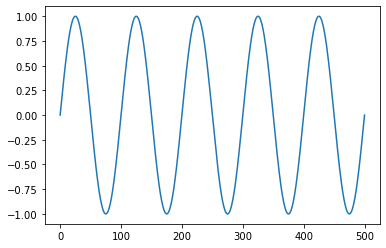

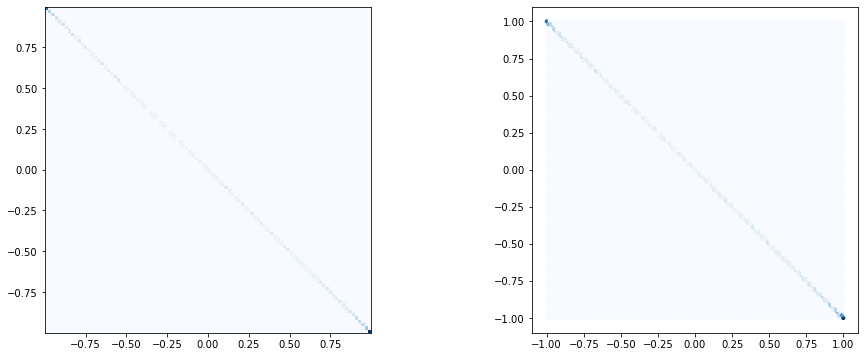

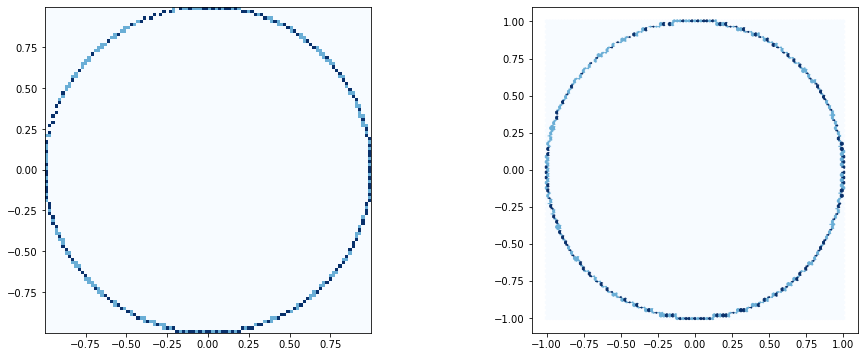

In [16]:
# test cases:
# sequential array
#bin2D(timeSeries=np.arange(100),tauIdx=5)
# random array
#bin2D(timeSeries=np.random.randint(0,101,100),tauIdx=5)
# correlated array
corr_arr = np.sin(np.linspace(0.,10.*np.pi,500))
plt.plot(corr_arr)
bin2D(timeSeries=corr_arr, tauIdx = 50) # non-optimal! 
bin2D(timeSeries=corr_arr, tauIdx = 25) # optimal! 50*n = perfect linear correlation

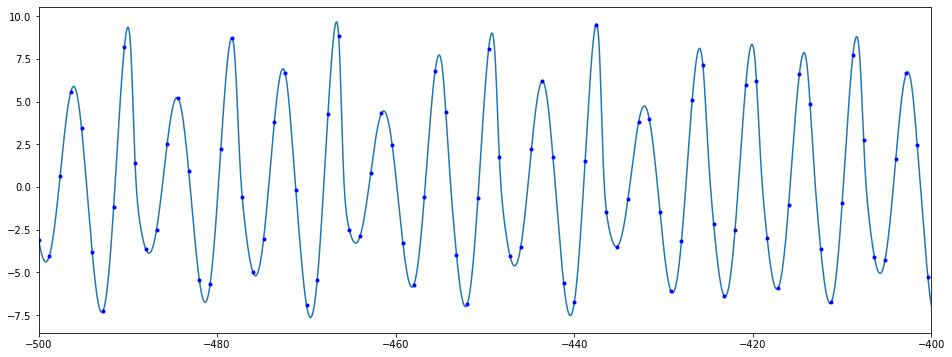

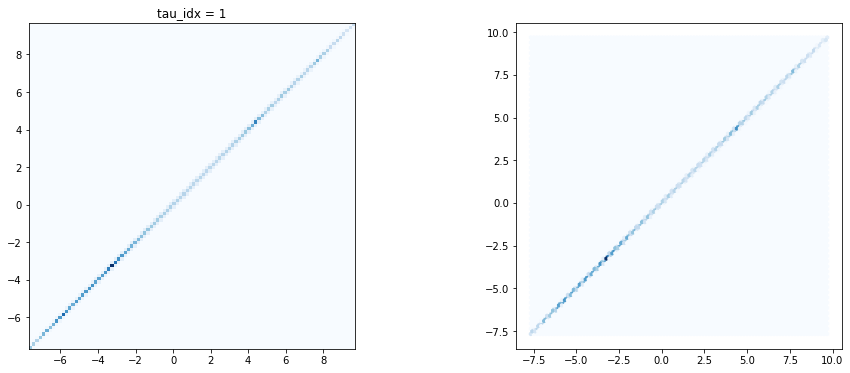

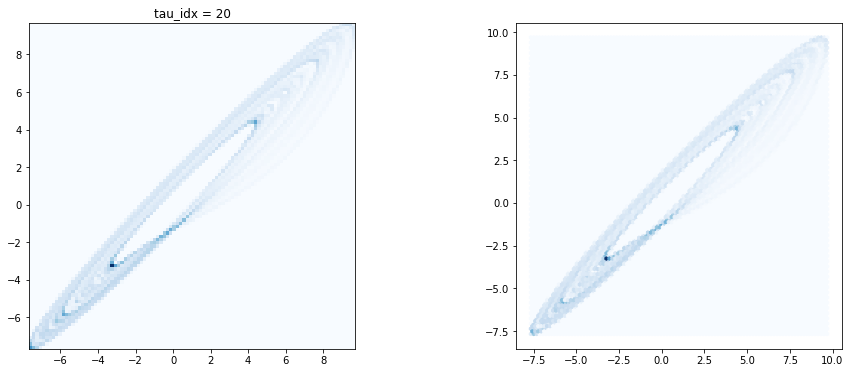

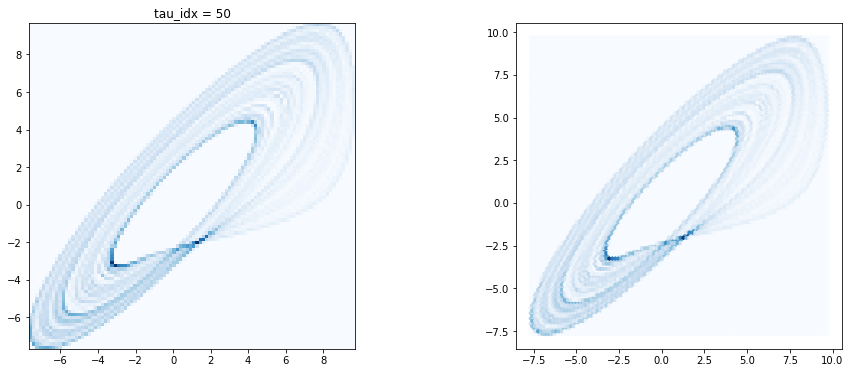

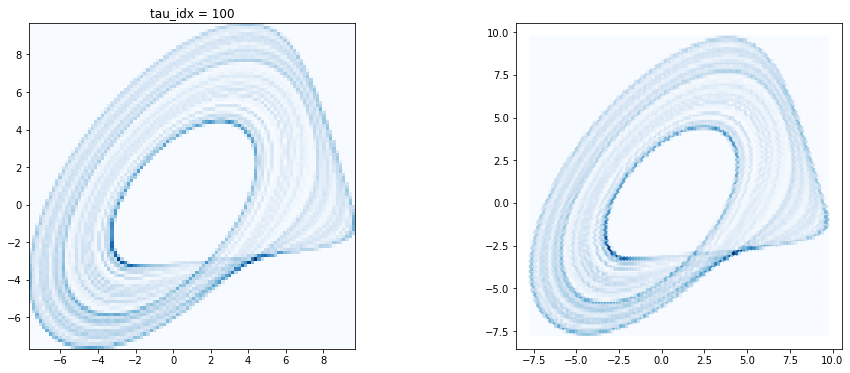

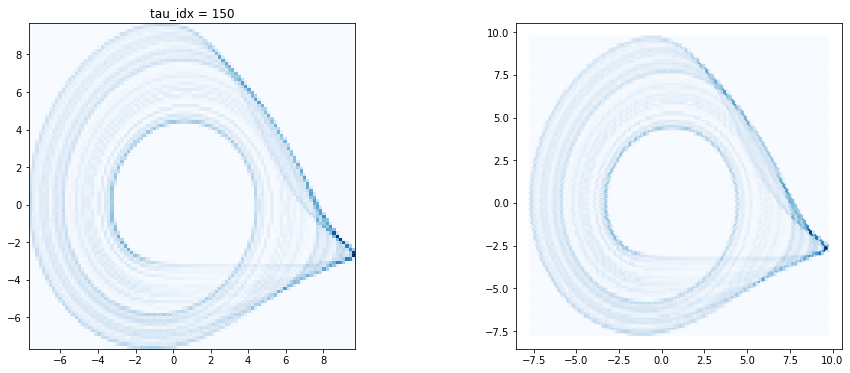

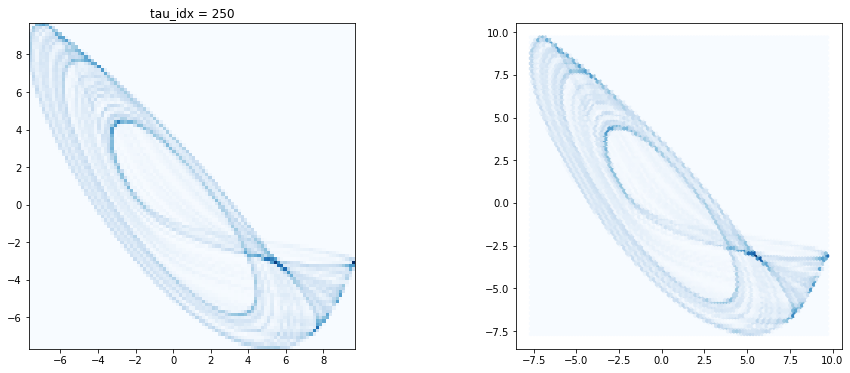

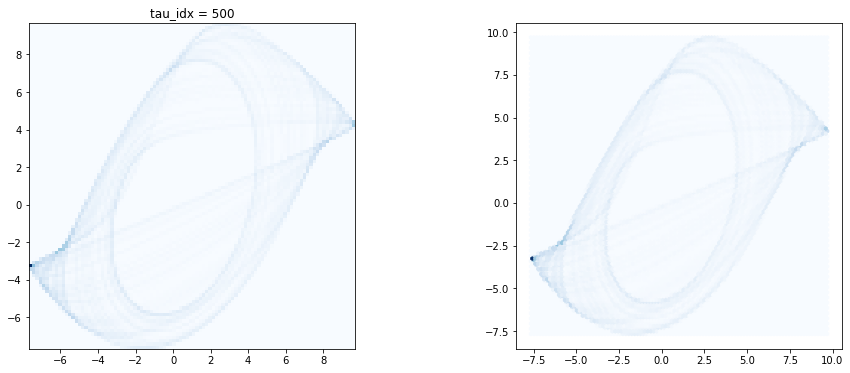

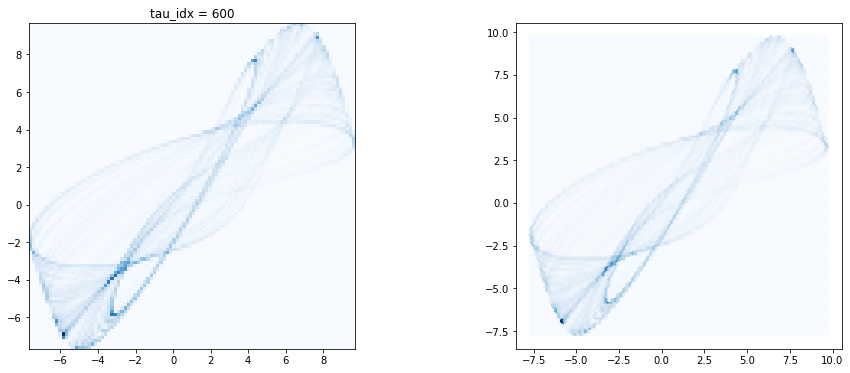

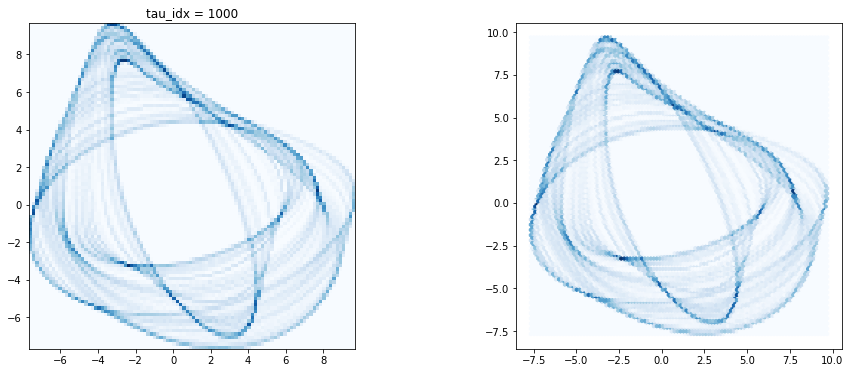

In [17]:
# rossler
testDelayIdxs = np.array((1,20,50,100,150,250,500,600,1000))
#testDelayIdxs = np.arange(1,201,10)
#testDelayIdxs = np.arange(110,130,10)
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(rossler_t,rossler_r[:,0])
#for i in testDelayIdxs:
#    ax.axvline(rossler_t[i],color='k')

# see where the nice-looking delays happen along the time series. remember: what makes a good delay is *minimal* correlation, not maximal! so
# the delay should not correspond to an inherent periodicity of the system.
delay = 120
ax.plot(rossler_t[::delay],rossler_r[::delay,0,],'b.')


ax.set_xlim(-500,-400)
plt.show()

for i in testDelayIdxs:
    bin2D(timeSeries=rossler_r[:,0], tauIdx = i, plotTitle="tau_idx = {0}".format(i))
#this is SO COOL
# so just by eye it looks like the first minimum of the mutual information should fall around tau~120 for the Rossler x time series.

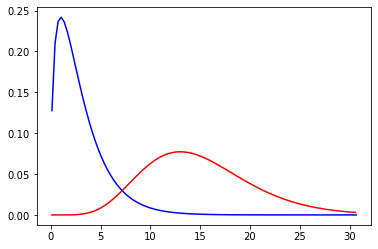

1.5472092253624832
1.287377140706061


In [18]:
#playing around with chi-squared test for significance of substructure in the joint probability distribution (see pages
# 5-6 of Fraser & Swinney 1986)
fig, ax = plt.subplots(1, 1)
x3 = np.linspace(chi2.ppf(0.01, df=3),chi2.ppf(0.999999, df=3), 100)
x15 = np.linspace(chi2.ppf(0.00000000000001, df=15),chi2.ppf(0.99, df=15), 100)
ax.plot(x3, chi2.pdf(x3, df=3),'b-')
ax.plot(x15, chi2.pdf(x15, df=15),'r-')
plt.show()

print(chi2.ppf(0.8,df=3)/3) #reduced chi squared (FS86 eq 21)
print(chi2.ppf(0.8,df=15)/15) #reduced chi squared (FS86 eq 22)


In [170]:
# steps:
# 1. binarize x(t) and y(t) = x(t + T), i.e. change of variables to s(t) and q(t) (see page 6)
#  "if the binary representations of s(t) and q(t) are available after the change of variable, then [s(t), q(t)] can be
#  assigned to the appropriate element of any partition G_m by inspection" --> how does this work?
#  i suppose because the partition is done by dividing into a grid of 4^m elements: each division corresponds to a power
#  of 2. the change of variables (x,y) -> (s,t) yields "sequences of known range and uniform density" which live in G_m.
#  conceptually I think I understand it but I want to make sure...it's the areas of the cells I guess that's tripping me up?

def xy_to_sq(x,y):
    
    t = len(x)
    
    n = 0
    while 2**n < t:
        n+=1
        
    # zero-pad
    xpad = np.zeros(2**n)
    ypad = np.zeros(2**n)
    
    xpad[0:2**n - t] = np.linspace(np.min(x) - 2, np.min(x) - 1, 2**n - t)
    ypad[0:2**n - t] = np.linspace(np.min(y) - 2, np.min(y) - 1, 2**n - t)
    
    xpad[-t:] = 1*x
    ypad[-t:] = 1*y
    
    print(xpad)
    print(ypad)
    
    fig,ax=plt.subplots(1,1,figsize=(8,6))
    ax.plot(xpad,ypad,'k.')
    ax.set_aspect('equal')
    plt.show()
    
    
    # change of variables
    s = np.arange(2**n)[np.argsort(xpad)]
    q = np.arange(2**n)[np.argsort(ypad)]
    
    print(s)
    print(q)
    fig,ax=plt.subplots(1,1,figsize=(8,6))
    ax.plot(s,q,'k.')
    ax.set_aspect('equal')
    plt.show()
    
    return s, q

# 2. implement chi-squared tests (equations 21, 22) to decide if a cell is subdivided enough or not
def partition_chisq():
    return


# 3. implement equation (19) to evaluate  i_m (where m is the level of recursion). Call the previous routines to 
# decide if going to level m+1 is necessary.
def FS86(timeSeries, tauIdx):
    x = timeSeries[:-tauIdx]
    y = timeSeries[tauIdx:]
    print(len(x))
    print(len(y))
    #print(x)
    #print(y)
    
    N_0 = len(x) # number of (x,y) pairs
    
    s, q = xy_to_sq(x,y)
    t = len(s)
    
    print(s)
    print(q)
    #print(t)
    
    # G_0 = 2**0 x 2**0 = 1x1
    # G_1 = 2**1 x 2**1 = 2x2
    # G_2 = 2**2 x 2**2 = 4x4 etc
    
    m = 0
    # do the next two grid subdivisions
    grids = []
    
    for m in range(0,3):
        nCells = 2**(m+1)
        N_grid = np.zeros((nCells, nCells))
    
        for i in range(nCells):
            for j in range(nCells):
                #print("i is {0}".format(i))
                #print("j is {0}".format(j))
                #print(t/nCells)
                #print(i*(t/nCells))
                #print(j*(t/nCells))

                cell_mask = ( s >= i * (t/nCells)) & (s < (i+1) * (t/nCells)) & ( q >= j * (t/nCells)) & (q < (j+1) * (t/nCells)) 
                #print(len(s[cell_mask]))
                N_grid[j,i] = len(s[cell_mask])
                #print(N_grid[j,i])

        #print(N_grid)
        grids.append(N_grid)
    
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    im = ax.imshow(grids[-1],cmap="Blues",origin="lower")
    ax.set_aspect("equal")
    cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    plt.colorbar(im,cax=cax)
    plt.show()
    
    
    
    I_0 = (1./N_0) * N_0*np.log(N_0)
    
    return

30
30
[-1.77357056 -0.77357056  4.11994131 10.45785737  8.05193336  6.58524333
  1.71620504  1.71593972  0.63891973  9.5279376   6.61226513  7.78879836
  0.22642944 10.66900837  9.15686905  2.33573022  2.00007464  2.01744961
  3.34666467  5.77232075  4.75139521  3.20352054  6.73038184  1.53443247
  3.21359113  4.02998028  5.01676983  8.63693558  2.1964116   5.65657882
  6.51656026  0.51095454]
[-1.72038961 -0.72038961  0.27961039  1.1868057   0.34572104  7.00051452
  3.45791579  5.5942776   9.98323121  2.74221452  4.51421215  8.31106252
  2.51677982  0.84677901  3.18726598  1.77343416 10.22667418  8.88932418
  6.96744132  9.58606649  8.84039285  2.05227065  9.81814898  5.93276466
  8.88184171  9.8570043   3.49803822  1.21057117  2.50728679  4.69818567
  8.99816243  9.46803642]


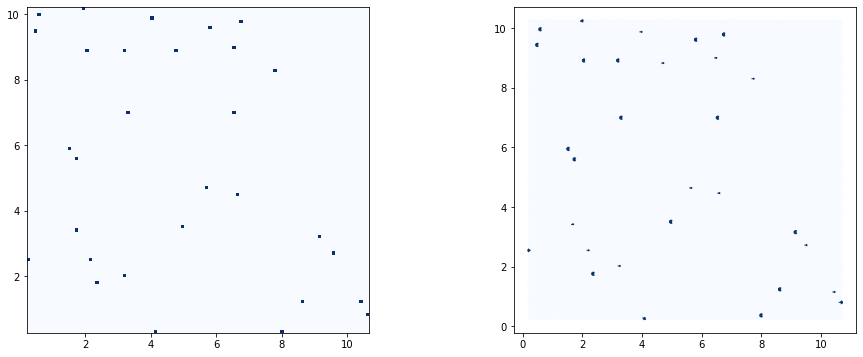

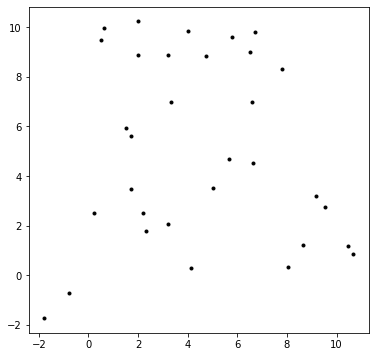

[ 0  1 12 31  8 23  7  6 16 17 28 15 21 24 18 25  2 20 26 29 19 30  5 10
 22 11  4 27 14  9  3 13]
[ 0  1  2  4 13  3 27 15 21 28 12  9 14  6 26 10 29  7 23 18  5 11 20 24
 17 30 31 19 22 25  8 16]


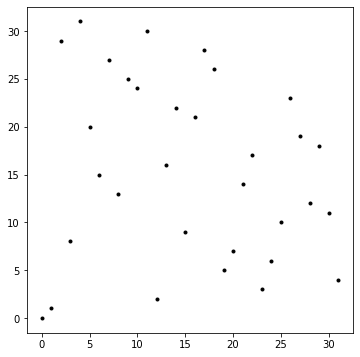

[ 0  1 12 31  8 23  7  6 16 17 28 15 21 24 18 25  2 20 26 29 19 30  5 10
 22 11  4 27 14  9  3 13]
[ 0  1  2  4 13  3 27 15 21 28 12  9 14  6 26 10 29  7 23 18  5 11 20 24
 17 30 31 19 22 25  8 16]


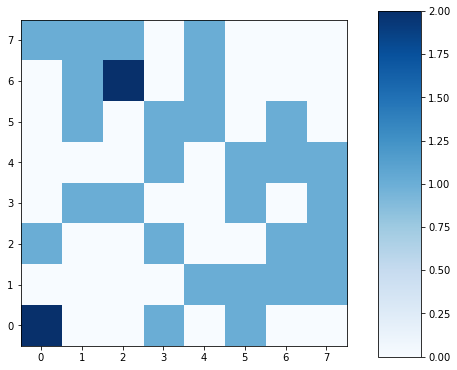

In [171]:
np.random.seed(42)
testRandom1 = np.random.uniform(0,11,size=128)

bin2D(timeSeries=testRandom1, tauIdx = 98,plotTitle=None)

FS86(timeSeries=testRandom1,tauIdx = 98)

# Choose embedding dimension

### Cao 1997

# Calculate correlation integral

### Grassberger & Procaccia 1983